Run next 5 cells if running on Colab

### Kaggle data download

In [85]:
!wget https://download1478.mediafire.com/b0dw1lqpm0wg/x0fkjgvejqsdato/kaggle.json

--2020-12-30 13:57:08--  https://download1478.mediafire.com/b0dw1lqpm0wg/x0fkjgvejqsdato/kaggle.json
Resolving download1478.mediafire.com (download1478.mediafire.com)... 205.196.123.166
Connecting to download1478.mediafire.com (download1478.mediafire.com)|205.196.123.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [application/json]
Saving to: ‘kaggle.json.1’

kaggle.json.1       100%[===================>]      63   411 B/s    in 0.2s    

2020-12-30 13:57:09 (411 B/s) - ‘kaggle.json.1’ saved [63/63]



In [86]:
!mkdir .kaggle
import json
token = {"username":"aiden98","key":"eba75dd5264ada538b85a5aa62a421af"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!kaggle config set -n path -v content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: content


In [87]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [88]:
!unzip /content/content/datasets/paultimothymooney/chest-xray-pneumonia/chest-xray-pneumonia.zip

Archive:  /content/content/datasets/paultimothymooney/chest-xray-pneumonia/chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Import Libraries

In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from tensorflow.compat.v1.keras import backend as K

color = sns.color_palette()
%matplotlib inline

Reproducibility is a great concern when doing deep learning. There was a good discussion on `KaggleNoobs` slack regarding this. We will set a numer of things in order to make sure that the results are almost reproducible(if not fully). 

In [2]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.compat.v1.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

The dataset is divided into three sets: 1) train set    2) validation set    and 3) test set.  Let's grab the dataset   

In [193]:
# Define path to the data directory
# data_dir = Path('/content/chest_xray') # i fon colab on comment this line and comment the next one
data_dir = Path('chest_xray')
# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

in_size = 224

### How many samples for each class are there in the dataset?

In [243]:
def show_dist(dir_):
    # Get the path to the normal and pneumonia sub-directories
    normal_cases_dir = dir_ / 'NORMAL'
    pneumonia_cases_dir = dir_ / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data = []

    # Go through all the normal cases. The label for these cases will be 0
    for img in normal_cases:
        data.append((img,0))

    # Go through all the pneumonia cases. The label for these cases will be 1
    for img in pneumonia_cases:
        data.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data = pd.DataFrame(data, columns=['image', 'label'],index=None)
    # Get the counts for each class
    cases_count = data['label'].value_counts()
    print(cases_count)

    # Plot the results 
    plt.figure(figsize=(3,2))
    sns.barplot(x=cases_count.index, y= cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
    plt.show()

1    3875
0    1341
Name: label, dtype: int64


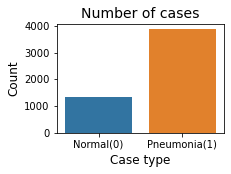

In [244]:
show_dist(train_dir)

1    8
0    8
Name: label, dtype: int64


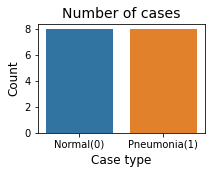

In [246]:
# small validation set!
# but since the uploder has decided the size I will o with it
show_dist(val_dir)

1    390
0    234
Name: label, dtype: int64


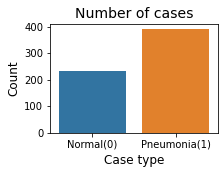

In [247]:
show_dist(test_dir)

### Under sampling
first we try the simple way, if undersampling work we wont need to bother ourselves with augmentation

In [186]:
# use 0 and 1 labels
lbl_dim = 1
# in order to have equal number of samples
# in each class we stop the loop with this
# variable
drop_samples = True

In [180]:
import pickle
# Get the path to the sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain traination images data and the corresponding labels
train_data = []
train_labels = []

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (in_size,in_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if lbl_dim == 1:
        label = 0 
    else:
        label = to_categorical(0, num_classes=2)
        
    train_data.append(img)
    train_labels.append(label)

i = len(train_data)
# Pneumonia cases        
for img in pneumonia_cases:
    if i == 0 and drop_samples == True:
        break
    i-=1
    img = cv2.imread(str(img))
    img = cv2.resize(img, (in_size,in_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if lbl_dim == 1:
        label = 1 
    else:
        label = to_categorical(0, num_classes=2)    
    
    train_data.append(img)
    train_labels.append(label)
    
# Convert the list into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

with open('train_data.pkl','wb') as f:
    pickle.dump(train_data,f)
with open('train_label.pkl','wb') as f:
    pickle.dump(train_labels,f)    
    
with open("train_data.pkl",'rb') as f:
    train_data = pickle.load(f)
with open("train_label.pkl",'rb') as f:
    train_labels = pickle.load(f)

print("Total number of train examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of train examples:  (2682, 224, 224, 3)
Total number of labels: (2682,)


C:\Users\BasuUser\Anaconda3\envs\moein2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


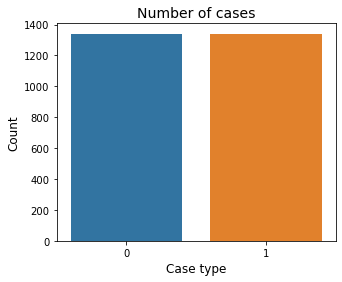

In [181]:
import seaborn as sns

# Plot the results 
plt.figure(figsize=(5,4))
sns.countplot(train_labels)

plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### Preparing validation and test data


In [194]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (in_size,in_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if lbl_dim == 1:
        label = 0 
    else:
        label = to_categorical(0, num_classes=2)
        
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (in_size,in_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if lbl_dim == 1:
        label = 1 
    else:
        label = to_categorical(0, num_classes=2)    
    
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

with open('val_data.pkl','wb') as f:
    pickle.dump(valid_data,f)
with open('val_label.pkl','wb') as f:
    pickle.dump(valid_labels,f)    
    
with open("val_data.pkl",'rb') as f:
    valid_data = pickle.load(f)
with open("val_label.pkl",'rb') as f:
    valid_labels = pickle.load(f)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16,)


In [190]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (in_size,in_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if lbl_dim == 1:
        label = 0 
    else:
        label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (in_size,in_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if lbl_dim == 1:
        label = 1
    else:
        label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624,)


### Training data generator 
Here I will define a very simple data generator. You can do more than this if you want but I think at this point, this is more than enough I need.

In [197]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.15,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.15,
    shear_range=0.,  # set range for random shear
    zoom_range=0.1)  # set range for random zoo

train_generator = train_data_gen.flow(
        train_data, train_labels,
        batch_size=batch_size)

In [199]:
batch_size = 32

# Define the number of training steps
steps_per_epoch = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(steps_per_epoch, len(valid_data)))

Number of training and validation steps: 83 and 16


In [200]:
transfer_lr = True
base_weights = None
normalize = True

activation_f = 'sigmoid'
loss_type = 'binary_crossentropy'

dout = 0.2
monitor = 'val_f1_m'
the_model= 'densenet121' #'resnet50'

In [201]:
in_size =224

in_dim =3
# here we freeze everything except the last layer
if transfer_lr:
    base_weights= 'imagenet'#the_model+'_weights_tf_dim_ordering_tf_kernels_notop.h5'

if the_model == 'resnet50':
    base_model = ResNet50(weights=base_weights, include_top=False)#, input_shape=(in_size,in_size,in_dim))
elif the_model == 'densenet121':
    base_model = DenseNet121(weights='../Neck X-Ray/densenet121_weights_tf_dim_ordering_tf_kernels_notop_2.h5', include_top=False)#, input_shape=(in_size,in_size,in_dim))
    
base_model.trainable = not transfer_lr

inputs = Input(shape=(in_size, in_size, in_dim))

if normalize:
    norm_layer = Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    x = norm_layer(inputs)
    norm_layer.set_weights([mean, var])
else:
    x = inputs
    
x = base_model(x, training = not transfer_lr)
x = GlobalAveragePooling2D()(x) # instead of dense layer
if dout!= 0.:
    x = Dropout(dout)(x) # Regularize with dropout
    
# final_neurons = num_classes
if activation_f=='sigmoid':
    final_neurons = 1

outputs = Dense(final_neurons, activation=activation_f)(x)

model = Model(inputs, outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization_5 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 7,038,536
Trainable params: 1,025
Non-trainable params: 7,037,511
_____________________________________________

In [40]:
!mkdir weights

A subdirectory or file weights already exists.


In [202]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [206]:
weight_address = 'weights/'+'best_model_todate_' + the_model + '.hdf5'

opt = Adam() 
es = EarlyStopping(patience=6, monitor=monitor)
chkpt = ModelCheckpoint(filepath=weight_address, save_best_only=True,
                        save_weights_only=True, monitor=monitor, mode='max')

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

lr_track = get_lr_metric(opt)

model.compile(loss= loss_type, metrics=['accuracy',f1_m,precision_m,recall_m], optimizer=opt)

In [204]:
print('Model:',the_model, ', classes:', 2, ', activation:',activation_f,', transfer learning:', transfer_lr,
      ", loss:", loss_type, '\n, normalized between [-1, 1]:', normalize, ', Batch size:', batch_size, ', in_size:', in_size
     , ', monitor: ', monitor)

Model: densenet121 , classes: 2 , activation: sigmoid , transfer learning: True , loss: binary_crossentropy 
, normalized between [-1, 1]: True , Batch size: 32 , in_size: 224 , monitor:  val_f1_m


In [24]:
!rm -rf utils
!git clone https://github.com/Moeinh77/utils
from utils.tools.clr_callback import CyclicLR
from utils.tools.learningratefinder import LearningRateFinder
from sklearn.metrics import confusion_matrix
print('Tools imported!')

'rm' is not recognized as an internal or external command,
operable program or batch file.


Tools imported!


fatal: destination path 'utils' already exists and is not an empty directory.


Using generator: True
  ...
    to  
  ['...']
Train for 83 steps
Epoch 1/4
83/83 [==============================] - 29s 346ms/step - loss: 1.0873 - accuracy: 0.5045 - f1_m: 0.0149 - lr: 3.8547e-06 - precision_m: 0.1084 - recall_m: 0.0081
Epoch 2/4
83/83 [==============================] - 22s 262ms/step - loss: 0.9280 - accuracy: 0.5185 - f1_m: 0.0767 - lr: 3.8547e-05 - precision_m: 0.4056 - recall_m: 0.0437
Epoch 3/4
83/83 [==============================] - 22s 262ms/step - loss: 0.6279 - accuracy: 0.6491 - f1_m: 0.5941 - lr: 3.8547e-04 - precision_m: 0.6888 - recall_m: 0.5562
Epoch 4/4
83/83 [==============================] - 22s 261ms/step - loss: 0.3667 - accuracy: 0.8532 - f1_m: 0.8509 - lr: 0.0039 - precision_m: 0.8626 - recall_m: 0.8498


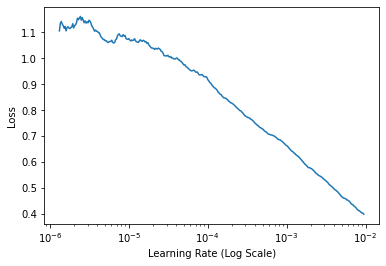

In [205]:
lrf = LearningRateFinder(model)
lrf.find(
    train_generator,
    1e-5, 1e-2,
    stepsPerEpoch=steps_per_epoch,
    batchSize=batch_size
    ,epochs=4)

lrf.plot_loss()

In [207]:
MIN_LR = 1e-5
MAX_LR = 3e-3
STEP_SIZE = 1
CLR_METHOD = "triangular"

clr = CyclicLR(
    mode= CLR_METHOD,
    base_lr= MIN_LR,
    max_lr= MAX_LR,
    step_size= STEP_SIZE * steps_per_epoch)

In [208]:
history=[]

In [209]:
nb_epochs = 8
# Fit the model
history.append(model.fit(train_generator, 
                              epochs=nb_epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=(valid_data,valid_labels),callbacks=[chkpt, clr]))


  ...
    to  
  ['...']
Train for 83 steps, validate on 16 samples
Epoch 1/8
83/83 [==============================] - 31s 371ms/step - loss: 0.5832 - accuracy: 0.7208 - f1_m: 0.6471 - precision_m: 0.7237 - recall_m: 0.6512 - val_loss: 0.3640 - val_accuracy: 0.9375 - val_f1_m: 0.9333 - val_precision_m: 1.0000 - val_recall_m: 0.8750
Epoch 2/8
83/83 [==============================] - 22s 264ms/step - loss: 0.2739 - accuracy: 0.9023 - f1_m: 0.8995 - precision_m: 0.9142 - recall_m: 0.8897 - val_loss: 0.3123 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - val_precision_m: 0.8750 - val_recall_m: 0.8750
Epoch 3/8
83/83 [==============================] - 22s 264ms/step - loss: 0.2589 - accuracy: 0.9015 - f1_m: 0.8967 - precision_m: 0.9183 - recall_m: 0.8820 - val_loss: 0.2981 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - val_precision_m: 0.8750 - val_recall_m: 0.8750
Epoch 4/8
83/83 [==============================] - 22s 265ms/step - loss: 0.2181 - accuracy: 0.9238 - f1_m: 0.9209 - precision_m: 0.93

Best train f1-acc: 0.9349570870399475 | Best val f1-acc: 0.9333332777023315


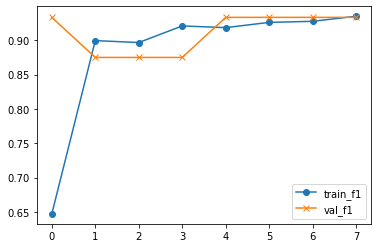

In [210]:
i = 0
print('Best train f1-acc: {} | Best val f1-acc: {}'.format(max(history[i].history['f1_m']),max(history[i].history['val_f1_m'])))
plt.plot(history[i].history['f1_m'],'o-')
plt.plot(history[i].history['val_f1_m'],'x-')
plt.legend(['train_f1','val_f1'])
plt.show()

In [211]:
model.save(weight_address[:-5]+'_frozen'+'.hdf5')

In [212]:
# Load the model weights
model.load_weights(weight_address)
# eval on test set
model.evaluate(test_data,test_labels)

624/624 [==============================] - 2s 3ms/sample - loss: 0.4113 - accuracy: 0.8381 - f1_m: 0.6049 - precision_m: 0.6500 - recall_m: 0.5666


[0.4112998277713091, 0.838141, 0.6048693, 0.65, 0.5666193]

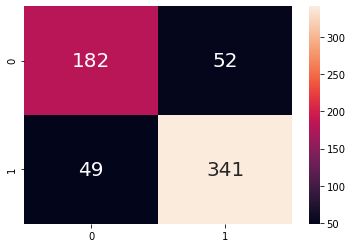

In [213]:
predictions = model.predict(test_data)

def binary_(i):
    if i> 0.5: 
        return 1
    else: 
        return 0
predictions = [binary_(float(i)) for i in predictions]
sns.heatmap(confusion_matrix(test_labels, 
                            predictions),annot=True,annot_kws={"size": 20},fmt='g')

plt.show()

well, not bad but maybe we can do better after fine tuning

In [215]:
# Load the model best weights and unfreeze for fine tune
base_model.trainable = True
############################################################
# adding regularization
penalty = 2
regularizer = tensorflow.keras.regularizers.l2(penalty)

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
            setattr(layer, attr, regularizer)

model_json = base_model.to_json()
base_model = tensorflow.keras.models.model_from_json(model_json)
if base_model.losses != []:
    print('Regularization applied with penalty ', penalty)
############################################################
model.compile(loss= loss_type, metrics=['accuracy',f1_m,precision_m,recall_m], optimizer=opt)
model.summary()

Regularization applied with penalty  2
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization_5 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 7,038,536
Trainable params: 6,954,881
Non-trainable params: 83,655
_____

Using generator: True
  ...
    to  
  ['...']
Train for 83 steps
Epoch 1/4
83/83 [==============================] - 42s 506ms/step - loss: 0.3083 - accuracy: 0.8883 - f1_m: 0.8826 - precision_m: 0.9049 - recall_m: 0.8670
Epoch 2/4
83/83 [==============================] - 31s 377ms/step - loss: 0.2965 - accuracy: 0.8894 - f1_m: 0.8855 - precision_m: 0.8985 - recall_m: 0.8775
Epoch 3/4
83/83 [==============================] - 32s 382ms/step - loss: 0.2262 - accuracy: 0.9215 - f1_m: 0.9171 - precision_m: 0.9268 - recall_m: 0.9122
Epoch 4/4
83/83 [==============================] - 32s 382ms/step - loss: 0.1820 - accuracy: 0.9351 - f1_m: 0.9332 - precision_m: 0.9400 - recall_m: 0.9306


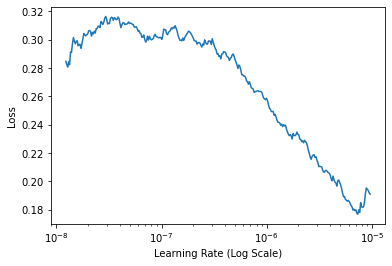

In [216]:
lrf = LearningRateFinder(model)
lrf.find(
    train_generator,
    1e-8, 1e-5,
    stepsPerEpoch=steps_per_epoch,
    batchSize=batch_size
    ,epochs=4)
# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()

In [217]:
MIN_LR = 5e-7
MAX_LR = 8e-6
STEP_SIZE = 1
CLR_METHOD = "triangular"

clr = CyclicLR(
    mode= CLR_METHOD,
    base_lr= MIN_LR,
    max_lr= MAX_LR,
    step_size= STEP_SIZE * steps_per_epoch)

In [218]:
nb_epochs = 20
# Fit the model

history.append(model.fit(train_generator, 
                              epochs=nb_epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=(valid_data, valid_labels),callbacks=[chkpt, clr]))


  ...
    to  
  ['...']
Train for 83 steps, validate on 16 samples
Epoch 1/20
83/83 [==============================] - 34s 412ms/step - loss: 0.2267 - accuracy: 0.9170 - f1_m: 0.9143 - precision_m: 0.9211 - recall_m: 0.9127 - val_loss: 0.2108 - val_accuracy: 0.9375 - val_f1_m: 0.9412 - val_precision_m: 0.8889 - val_recall_m: 1.0000
Epoch 2/20
83/83 [==============================] - 33s 394ms/step - loss: 0.1339 - accuracy: 0.9517 - f1_m: 0.9500 - precision_m: 0.9546 - recall_m: 0.9479 - val_loss: 0.0999 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 3/20
83/83 [==============================] - 32s 383ms/step - loss: 0.1076 - accuracy: 0.9623 - f1_m: 0.9606 - precision_m: 0.9700 - recall_m: 0.9535 - val_loss: 0.0806 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/20
83/83 [==============================] - 32s 383ms/step - loss: 0.1037 - accuracy: 0.9619 - f1_m: 0.9603 - precision_m: 

Best train f1-acc: 0.9883437752723694 | Best val f1-acc: 1.0


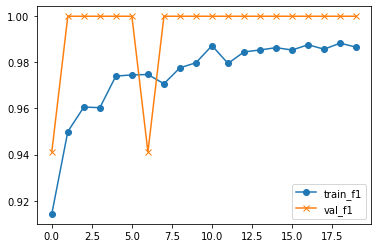

In [219]:
i = 1
print('Best train f1-acc: {} | Best val f1-acc: {}'.format(max(history[i].history['f1_m']),max(history[i].history['val_f1_m'])))
plt.plot(history[i].history['f1_m'],'o-')
plt.plot(history[i].history['val_f1_m'],'x-')
plt.legend(['train_f1','val_f1'])
plt.show()

In [220]:
# Evaluation on test dataset
results = model.evaluate(valid_data, valid_labels, batch_size=16)

print("Loss on valid set: ", results[0])
print("Accuracy on valid set: ", results[1])
print("F1 Accuracy on valid set: ", results[2])

16/16 [==============================] - 3s 198ms/sample - loss: 0.0181 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000
Loss on valid set:  0.018132871016860008
Accuracy on valid set:  1.0
F1 Accuracy on valid set:  1.0


In [221]:
# Evaluation on test dataset
results = model.evaluate(test_data, test_labels, batch_size=16)

print("Loss on test set: ", results[0])
print("Accuracy on test set: ", results[1])
print("F1 Accuracy on test set: ", results[2])

624/624 [==============================] - 2s 3ms/sample - loss: 0.2368 - accuracy: 0.9359 - f1_m: 0.6300 - precision_m: 0.6410 - recall_m: 0.6202       ETA: 1s - loss: 0.0757 - accuracy: 0.9732 - f1_m: 0.0000e+00 - precision_m: 0
Loss on test set:  0.23679266640176186
Accuracy on test set:  0.9358974
F1 Accuracy on test set:  0.63004667


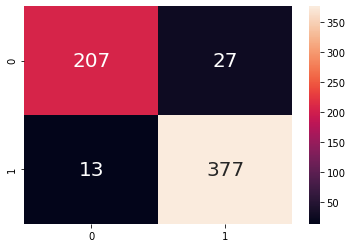

In [223]:
predictions = model.predict(test_data)

def binary_(i):
    if i> 0.5: 
        return 1
    else: 
        return 0
predictions = [binary_(float(i)) for i in predictions]
sns.heatmap(confusion_matrix(test_labels, 
                            predictions),annot=True,annot_kws={"size": 20},fmt='g')

plt.show()

we can see that we managed to predict the labels of 61 more samples after fine tuning